<a href="https://colab.research.google.com/github/alouwyck/PhD/blob/main/chapter11_water_budget_myth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

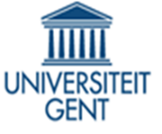<br>

**Axisymmetric Flow in Multilayer Aquifer Systems:**<br>
**Solutions and Theoretical Considerations**<br><br>
Andy Louwyck (2023)

---



---

# **CHAPTER 11: The Water Budget Myth and Its Recharge Controversy: Linear versus Nonlinear Systems**

This Jupyter notebook contains the Python code that implements the analytical solutions and the numerical example discussed in chapter 11 of my PhD thesis (Louwyck, 2023), which is an extended version of the paper by Louwyck et al. (2023).

## Import statements

Import the required packages, modules, and functions.

In [34]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
import matplotlib.pyplot as plt
import scipy as sp
from scipy.special import i0, i1, k0, k1, expi
from scipy.optimize import fsolve  # root finding

In [35]:
# check versions

print(np.__version__)
print(mpl.__version__)
print(sp.__version__)

1.22.4
3.7.1
1.10.1


## Bredehoeft's island

The circular island example from Bredehoeft et al. (1982) and Bredehoeft (2002):

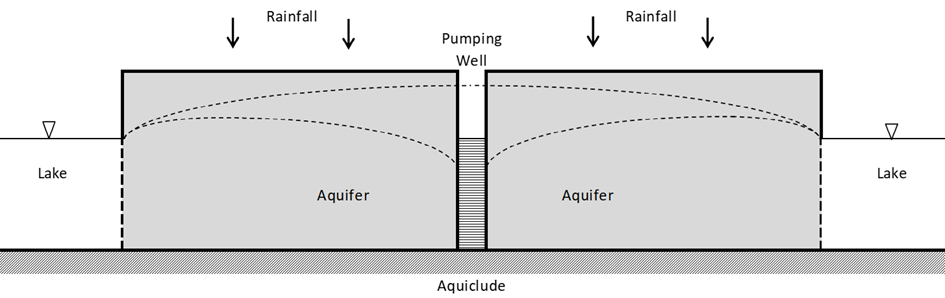

Solution for unconfined well-flow subject to recharge (Verruijt, 1970):

In [36]:
def unconfined(r, K, N, Q, rc, hc):
    '''
    calculates head for steady unconfined flow to a well in a homogeneous aquifer with recharge
    (equation 12)
    r: radial distance [L] (array-like)
    K: aquifer conductivity [L/T] (float)
    N: infiltration flux [L/T] (float)
    Q: pumping rate [L³/T] (float)
    rc: radial distance [L] of outer model boundary (float)
    hc: constant head [L] at outer model boundary (float)
    returns array h with hydraulic heads [L] at distances r
    '''
    r = np.array(r)
    return np.sqrt(hc**2 + N/2/K * (rc**2 - r**2) + Q/np.pi/K * np.log(r/rc))

Thiem (1870, 1906) equation for confined well-flow:

In [37]:
def thiem(r, T, Q, rc, hc=0.0):
    '''
    calculates head according to the Thiem (1870, 1906) formula (equation 17)
    r: radial distance [L] (array-like)
    T: aquifer transmissivity [L²/T] (float)
    Q: pumping rate [L³/T] (float)
    rc: radial distance [L] of outer model boundary (float)
    hc: constant head [L] at outer model boundary (float, default is 0.0)
    returns array h with hydraulic heads [L] at distances r
    '''
    r = np.array(r)
    return hc + Q/2/np.pi/T * np.log(r/rc)

Example:

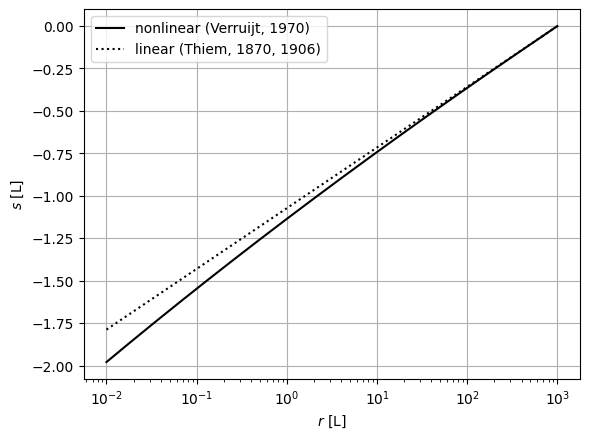

In [40]:
rc = 1000  # outer model boundary = radius [L] of island
hc = 10  # constant head at outer boundary = water level [L] in lake
r = np.logspace(-2, np.log10(rc), 1000)  # radial distances [L]
K = 10  # horizontal aquifer conductivity [L/T]
N = 1e-4  # infiltration flux [L/T]
Q = 100  # pumping rate [L³/T]

h0 = unconfined(r=r, K=K, N=N, Q=0, rc=rc, hc=hc)  # initial steady head h0 [L]
h = unconfined(r=r, K=K, N=N, Q=Q, rc=rc, hc=hc)  # steady head h [L] during pumping
T = K * h0[0]  # aquifer transmissivity [L²/T] estimated using the initial saturated thickness at the well
s = thiem(r=r, T=T, Q=Q, rc=rc)  # drawdown s [L] calculated using the Thiem equation

# plot
plt.semilogx(r, h - h0, 'k-',  # nonlinear: drawdown s = h - h0
             r, s, 'k:');      # linear: s calculated directly
plt.grid();
plt.xlabel('$r$ [L]');
plt.ylabel('$s$ [L]');
plt.legend(['nonlinear (Verruijt, 1970)', 'linear (Thiem, 1870, 1906)']);

## Polder island

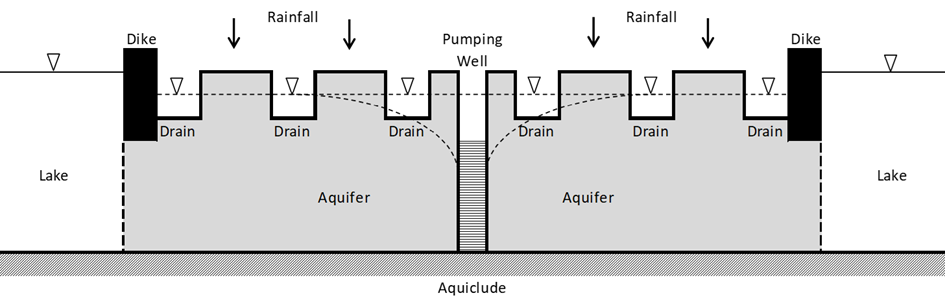

Nonlinear Ernst (1971) solution:

In [61]:
def ernst(r, T, c, N, Q, rw=0.0):
    '''
    calculates head according to the Ernst (1971) solution
    r: radial distance [L] (array-like)
    T: aquifer transmissivity [L²/T] (float)
    c: drainage resistance [T] (float)
    N: infiltration flux [L/T] (float)
    Q: pumping rate [L³/T] (float)
    rw: well-radius, i.e. radial distance [L] of the inner model boundary (float, default is 0.0)
    returns array h with hydraulic heads [L] at distances r
    '''
    rd = find_rd(T, c, N, Q)
    h = np.zeros(r.shape)
    b = r <= rd
    h[b] = hprox(r[b], T, N, Q, rd, rw)
    b = ~b
    h[b] = hdist(r[b], T, c, N, Q, rd)
    return h

def find_rd(T, c, N, Q):
    '''
    finds boundary between proximal and distal zone by solving hdist(r=rd) == 0
    T: aquifer transmissivity [L²/T] (float)
    c: drainage resistance [T] (float)
    N: infiltration flux [L/T] (float)
    Q: pumping rate [L³/T] (float)
    returns float rd which is the radial distance [L] of the boundary between proximal and distal zone
    '''
    return fsolve(lambda rd: hdist(rd, T, c, N, Q, rd), 1)[0]

def hprox(r, T, N, Q, rd, rw=0.0):
    '''
    calculates head in the proximal zone (equation 31)
    r: radial distance [L] (array-like)
    T: aquifer transmissivity [L²/T] (float)
    N: infiltration flux [L/T] (float)
    Q: pumping rate [L³/T] (float)
    rd: radial distance [L] of boundary between proximal and distal zone (float)
    rw: well-radius, i.e. radial distance [L] of the inner model boundary (float, default is 0.0)
    returns array h with hydraulic heads [L] at distances r
    '''
    return (N*rw**2/2/T + Q/2/np.pi/T) * np.log(r/rd) + N/4/T*(rd**2-r**2)

def hdist(r, T, c, N, Q, rd):
    '''
    calculates head in the distal zone (equation 33)
    r: radial distance [L] (array-like)
    T: aquifer transmissivity [L²/T] (float)
    c: drainage resistance [T] (float)
    N: infiltration flux [L/T] (float)
    Q: pumping rate [L³/T] (float)
    rd: radial distance [L] of boundary between proximal and distal zone (float)
    returns array h with hydraulic heads [L] at distances r
    '''
    L = np.sqrt(T*c)  # leakage factor [L]
    return (np.pi*N*rd**2-Q)/2/np.pi/T * L/rd * k0(r/L)/k1(rd/L) + N*c

Linear de Glee (1930) solution:

In [62]:
def de_glee(r, T, c, Q, h0=0.0):
    '''
    calculates head according to the de Glee (1930) equation
    r: radial distance [L] (array-like)
    T: aquifer transmissivity [L²/T] (float)
    c: resistance [T] (float)
    Q: pumping rate [L³/T] (float)
    h0: initial head [L] (float, default is 0.0)
    returns array h with hydraulic heads [L] at distances r
    '''
    return h0 - Q/2/np.pi/T * k0(r/np.sqrt(T*c))

Example:

In [63]:
Q = 100  # pumping rate [L³/T]
T = 100   # transmissivity [L²/T]
N = 1e-4  # infiltration rate [L/T]
c = 100   # resistance [T]

Find distance `rd` of boundary between proximal and distal zone:

In [64]:
rd = find_rd(T, c, N, Q)
rd

464.58804005477117

Comparison between solutions of Ernst (1971) and de Glee (1930):

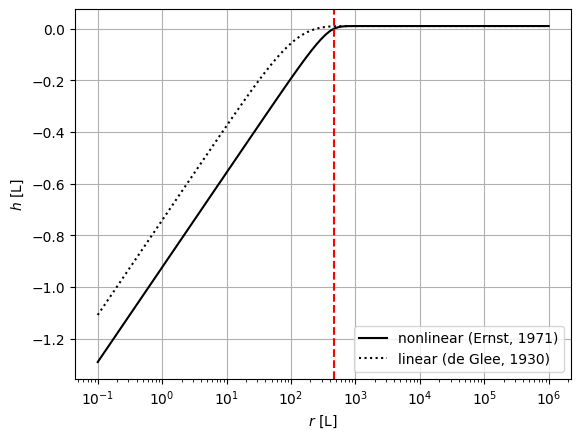

In [65]:
r = np.logspace(-1, 6, 100)  # distances r [L]
plt.semilogx(r, ernst(r, T, c, N, Q), 'k-');  # Ernst (1971)
plt.semilogx(r, de_glee(r, T, c, Q, h0=N*c), 'k:');  # de Glee (1930)
yl = plt.ylim()
plt.semilogx([rd, rd], yl, 'r--')  # distance rd
plt.ylim(yl)
plt.grid();
plt.xlabel('$r$ [L]');
plt.ylabel('$h$ [L]');
plt.legend(['nonlinear (Ernst, 1971)', 'linear (de Glee, 1930)']);

## Numerical example

The hypothetical case presented by Zhou (2009) is simulated in this example. A homogeneous aquifer is considered bounded by a river in the west, a drainage canal in the east, and no-flow boundaries in the north and the south. The extent of the aquifer is 5500 m by 5500 m, the saturated thickness is 60 m, the hydraulic conductivity is 20 m/d, the specific yield is 0.25. Infiltration recharges the aquifer at a constant rate of 1 mm/d. In the center, water is pumped from the aquifer at a constant rate of 24000 m³/d, which corresponds to Zhou’s (2009) first pumping case. The model grid consists of 1 layer, 55 rows of equal height, and 55 columns of equal width. The river stage is 100 m, the drainage level is 95 m; resistances or conductances are not mentioned by Zhou (2009), neither is the layer type. By trial and error, the same result was obtained keeping the saturated thickness constant, and setting river and drainage conductance to 26 m²/d and 24 m²/d, respectively.

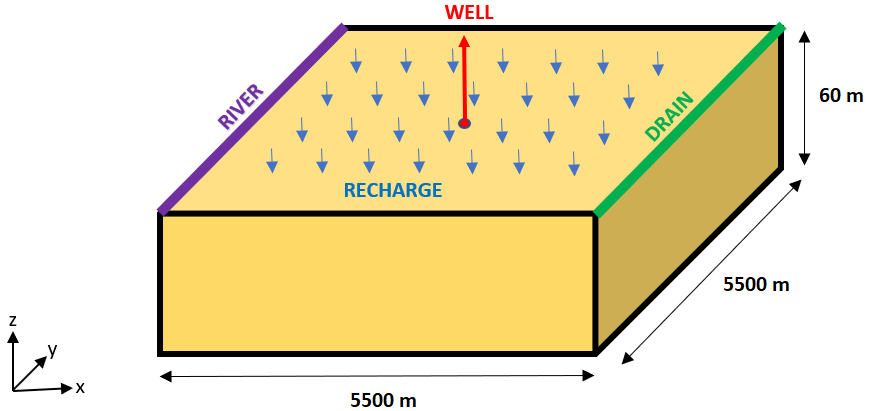

If the model is linear, drawdown can be simulated directly using the following function:

In [73]:
def zhou(D, L, m, K, Q, Criv, Cdrn, N=None):
    '''
    Simulates steady drawdown for the Zhou (2009) model.
    The model is assumed linear, which implies constant transmissivity and
    a drain boundary condition that doesn't go dry.
    D: aquifer thickness [L] (float)
    L: size [L] of the grid cells (float)
    m: number of rows, which equals the number of columns (int)
    K: aquifer conductivity [L/T] (float)
    Q: total pumping rate [L³/T] (float)
    Criv: conductance [L²/T] of the river in the first column (float)
    Cdrn: conductance [L²/T] of the drain in the last column (float)
    N: recharge flux [L/T] (float, default is None)
    returns m x m array s with the simulated drawdown [L] in each grid cell
    '''
    # input
    n = m * m  # total number of cells
    T = K * D  # transmissivity [L²/T]
    # construct matrix A
    T1 = T * np.ones(n-1)
    T1[np.arange(m-1, n-1, m)] = 0
    T2 = T * np.ones((m, m-1))
    T2 = T2.flatten()
    A = -np.diag(T1, 1) - np.diag(T1, -1) - np.diag(T2, m) - np.diag(T2, -m)
    i = np.arange(n)
    A[i, i] = -A.sum(axis=1)
    # add river
    i = np.arange(0, n, m)
    A[i, i] += Criv
    # add drain
    i += m-1
    A[i, i] += Cdrn
    # construct rhs vector b
    b = np.zeros(n)
    # add recharge if N is not None
    if N is not None:
        b -= N * L * L
    # add well
    b[n//2] = Q
    # solve system of equations to find drawdown s
    s = np.linalg.solve(A, b)
    return np.reshape(s, (m, m))

Simulating the example:

In [75]:
D = 60  # aquifer thickness (m)
K = 20  # aquifer conductivity (m/d)
Q = 24000  # total pumping rage (m³/d)
m = 55  # number of rows and columns
L = 100  # cell size (m)
Criv = 26 # river conductance (m²/d)
Cdrn = 24 # drain conductance (m²/d)
print(L**2/Criv, L**2/Cdrn)  # river and drain resistances (d)

384.61538461538464 416.6666666666667


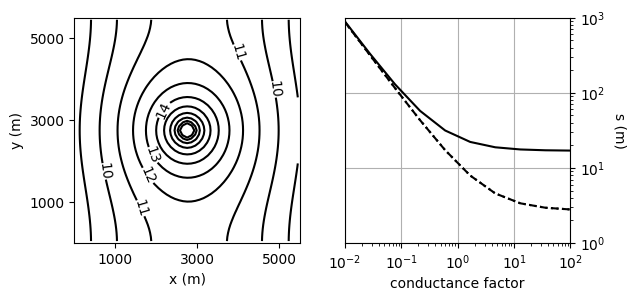

In [76]:
# left plot
s = zhou(D, L, m, K, Q, Criv, Cdrn)
x = np.arange(50, 5500, 100)
x, y = np.meshgrid(x, x)

fig, (ax1, ax2) = plt.subplots(1, 2)
cs2 = ax1.contour(x, y, s , levels=np.arange(9, 20, 1), colors='k');
ax1.clabel(cs2, cs2.levels[1:-5], inline=True, fmt='%d', fontsize=10);
ax1.set(xlim=(0, 5500), ylim=(0, 5500), aspect='equal', xlabel='x (m)', ylabel='y (m)',
        xticks=np.arange(1000, 5500, 2000), yticks=np.arange(1000, 5500, 2000));

# right plot
fac = np.logspace(-2, 2, 10)
s = np.zeros((m, m, len(fac)))
for i in range(len(fac)):
    s[:, :, i] = zhou(D, L, m, K, Q, Criv*fac[i], Cdrn*fac[i])

j = m//2
ax2.loglog(fac, s[j, j], 'k-', fac, s[0, j], 'k--', fac, s[-1, j], 'k:');
ax2.grid('on');
ax2.set(xlim=(0.01, 100), xlabel='conductance factor', ylim=(1, 1000), aspect=4./3.);
ax2.yaxis.tick_right();
ax2.yaxis.set_label_position("right");
ax2.set_ylabel('s (m)', rotation=270, labelpad=15);

Function to calculate the change in discharge of river and drain:

In [83]:
def dQ(s, Criv, Cdrn):
    '''
    Simulates change in discharge of river and drain for the linear Zhou (2009) model.
    s: simulated drawdown [L] (array)
    Criv: conductance [L²/T] of the river in the first column (float)
    Cdrn: conductance [L²/T] of the drain in the last column (float)
    returns tuple (dQriv, dQdrn)
      with dQriv and dQdrn the total change in discharge [L³/T] of river and drain, resp.
    '''
    m = s.shape[0]
    n = s.size
    c = np.zeros(n)
    i = np.arange(0, n, m)
    c[i] = Criv
    dQriv = np.sum(np.dot(np.diag(c), -s.flatten()))
    c = np.zeros(n)
    i += m-1
    c[i] = Cdrn
    dQdrn = np.sum(np.dot(np.diag(c), -s.flatten()))
    return dQriv, dQdrn

Relative contribution (in %) to total capture of river and drain, resp.:

In [84]:
s = zhou(D, L, m, K, Q, Criv, Cdrn)
dQriv, dQdrn = dQ(s, Criv, Cdrn)
print('river:', 100*-dQriv/Q, '\ndrain:', 100*-dQdrn/Q)

river: 51.28073770491793 
drain: 48.71926229508193


## References

- Bredehoeft, J. D. (2002). The Water Budget Myth Revisited: Why Hydrogeologists Model. Ground Water, 40(4). https://doi.org/10.1111/j.1745-6584.2002.tb02511.x
- Bredehoeft, J. D., Papadopulos, S. S., & Cooper, H. H. (1982). The water budget myth. In Scientific Basis of Water Resources management Studies in Geophysics (pp. 51–57). National Academy Press. https://nap.nationalacademies.org/read/19530/chapter/7
- de Glee, G. J. (1930). Over grondwaterstroomingen bij wateronttrekking door middel van putten (in Dutch) (PhD thesis). Technische Hoogeschool Delft, Drukkerij J. Waltman. Jr., Delft. http://resolver.tudelft.nl/uuid:c3e13209-4626-41b9-9038-c223d61e35c4
- Ernst, L. F. (1971). Analysis of groundwater flow to deep wells in areas with a non-linear function for the subsurface drainage. Journal of Hydrology, 14(2). https://doi.org/10.1016/0022-1694(71)90004-7
- Louwyck, A. (2023). Axisymmetric Flow in Multilayer Aquifer Systems: Solutions and Theoretical Considerations. PhD thesis, Laboratory for Applied Geology and Hydrogeology, Department of Geology, Ghent University, Belgium.
- Louwyck, A., Vandenbohede, A., Heuvelmans, G., Van Camp, M., & Walraevens, K. (2023). The Water Budget Myth and Its Recharge Controversy: Linear vs. Nonlinear Models. Groundwater, 61(1), 100–110. https://doi.org/10.1111/gwat.13245
- Thiem, A. (1870). Die Ergiebigkeit artesischer Bohrlöcher, Schachtbrunnen und Filtergalerien (in German). Journal Für Gasbeleuchtung Und Wasserversorgung, 13, 450–467.
- Thiem, G. (1906). Hydrologische Methoden (in German). Leipzig: Gebhardt.
- Verruijt, A. (1970). Theory of Groundwater Flow. London: Macmillan Press.
- Zhou, Y. (2009). A critical review of groundwater budget myth, safe yield and sustainability. Journal of Hydrology, 370(1–4). https://doi.org/10.1016/j.jhydrol.2009.03.009

---